## Deep Learning Basics with PyTorch
## Part III – Supervised Deep Learning in Practice
### Chapter 9 — Working with Data in PyTorch

In [1]:
# Ensure required packages are available (already installed in this env)
# !pip -q install torch numpy matplotlib scikit-learn
import torch, numpy as np, matplotlib.pyplot as plt  # PyTorch, NumPy, and plotting
from torch import nn  # Neural network modules
from torch.utils.data import TensorDataset, DataLoader, Dataset  # Dataset and DataLoader utilities
from sklearn.datasets import make_moons  # Synthetic 2D classification dataset
from sklearn.model_selection import train_test_split  # Train/test split helper
# Render Matplotlib plots with high-DPI for clarity in the notebook
%config InlineBackend.figure_format = 'retina'

## Dataset and DataLoader (moons)

In [2]:
# Reproducibility for PyTorch ops
torch.manual_seed(0)  # set global RNG seed

# Create a two-moons toy dataset for binary classification
X, y = make_moons(n_samples=600, noise=0.25, random_state=0)  # features (N,2) and labels (N,)

# Stratified split to preserve class balance in train and test
X_tr, X_te, y_tr, y_te = train_test_split(  # split into train/test subsets
    X, y, test_size=0.25, random_state=42, stratify=y  # 75% train / 25% test with fixed seed
)

# Convert NumPy arrays to PyTorch tensors with appropriate dtypes
X_tr = torch.tensor(X_tr, dtype=torch.float32)  # training features as float32
X_te = torch.tensor(X_te, dtype=torch.float32)  # test features as float32
y_tr = torch.tensor(y_tr, dtype=torch.long)  # training labels as class indices
y_te = torch.tensor(y_te, dtype=torch.long)  # test labels as class indices

# Wrap tensors in TensorDataset + DataLoader for mini-batch iteration
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=64, shuffle=True)  # shuffled mini-batches
test_loader  = DataLoader(TensorDataset(X_te, y_te), batch_size=256)  # larger eval batches

# Define a tiny MLP classifier: 2 -> 16 -> 2 with ReLU
class TinyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(  # sequential container of layers
            nn.Linear(2, 16),  # input layer from 2 features to 16 hidden units
            nn.ReLU(),  # nonlinearity
            nn.Linear(16, 2)  # output logits for 2 classes
        )

    def forward(self, x):
        return self.net(x)  # forward pass delegates to sequential network

# Instantiate model, optimizer, and loss function
model = TinyMLP()  # MLP instance
opt = torch.optim.Adam(model.parameters(), lr=5e-3)  # Adam optimizer
loss_fn = nn.CrossEntropyLoss()  # multi-class cross entropy on logits


In [3]:
# Train for a small number of epochs over mini-batches
for epoch in range(10):  # iterate over epochs
    model.train()  # set model to training mode
    for Xb, yb in train_loader:  # iterate over mini-batches
        logits = model(Xb)  # forward pass to get class logits
        loss = loss_fn(logits, yb)  # compute cross-entropy loss
        opt.zero_grad()  # clear previous gradients
        loss.backward()  # backpropagate to compute gradients
        opt.step()  # update parameters

# Evaluate simple accuracy on the test set
model.eval()  # set model to eval mode
with torch.no_grad():  # disable autograd for evaluation
    accuracy = (model(X_te).argmax(1) == y_te).float().mean().item()  # compute accuracy
accuracy  # display result in notebook output


0.8600000143051147

## Transform: standardization

In [4]:
# Define a simple standardization callable usable as a transform
class Standardize:
    def __init__(self, mean, std):
        self.mean = mean  # per-feature mean (tensor or array)
        self.std = std  # per-feature std (tensor or array)

    def __call__(self, x):
        return (x - self.mean) / (self.std + 1e-8)  # normalize and avoid division by zero

# Fit transform parameters on training data and apply to train/test
mu, sigma = X_tr.mean(0), X_tr.std(0)  # per-feature mean and std on train set
std = Standardize(mu, sigma)  # create transform instance
X_tr_s, X_te_s = std(X_tr), std(X_te)  # standardized tensors

# Rebuild loaders with standardized features (labels unchanged)
train_loader = DataLoader(  # training loader with standardized inputs
    TensorDataset(X_tr_s, y_tr), batch_size=64, shuffle=True
)
test_loader = DataLoader(  # test loader with standardized inputs
    TensorDataset(X_te_s, y_te), batch_size=256
)


## Custom collate (variable length)

In [5]:
# Create a toy sequence dataset of variable-length sequences and parity labels
class ToySeq(Dataset):
    def __init__(self, rng, n=20):
        # Generate n sequences of random integers in [1, 9], length between 3 and 7
        self.x = [torch.tensor(rng.integers(1, 10, size=rng.integers(3, 8))) for _ in range(n)]
        # Label is parity (even/odd) of the sum across each sequence
        self.y = [int(xi.sum() % 2) for xi in self.x]

    def __len__(self):
        return len(self.x)  # number of sequences

    def __getitem__(self, i):
        return self.x[i].float(), self.y[i]  # return float tensor and integer label

# Collate function to left-pad sequences in a batch to the same length

def pad_collate(batch):
    xs, ys = zip(*batch)  # unzip sequences and labels
    L = max(x.size(0) for x in xs)  # max length in batch
    Xp = torch.zeros(len(xs), L)  # padded batch tensor (B, L)
    for i, x in enumerate(xs):  # copy each sequence to the left-aligned slice
        Xp[i, :x.size(0)] = x  # pad with zeros to the right
    return Xp, torch.tensor(ys, dtype=torch.long)  # stacked padded tensor and labels

# Example usage: build a loader and fetch a sample batch
rng = np.random.default_rng(0)  # deterministic NumPy RNG
seq_loader = DataLoader(ToySeq(rng), batch_size=4, collate_fn=pad_collate)  # DataLoader with custom collate
xb, yb = next(iter(seq_loader))  # take first batch
xb.shape, yb.shape  # show padded shapes


(torch.Size([4, 7]), torch.Size([4]))

## Visualizations
- **Two-moons train/test scatter**
- **TinyMLP decision boundary**
- **Standardization: histograms and scatter**
- **ToySeq padded batch heatmap + lengths**

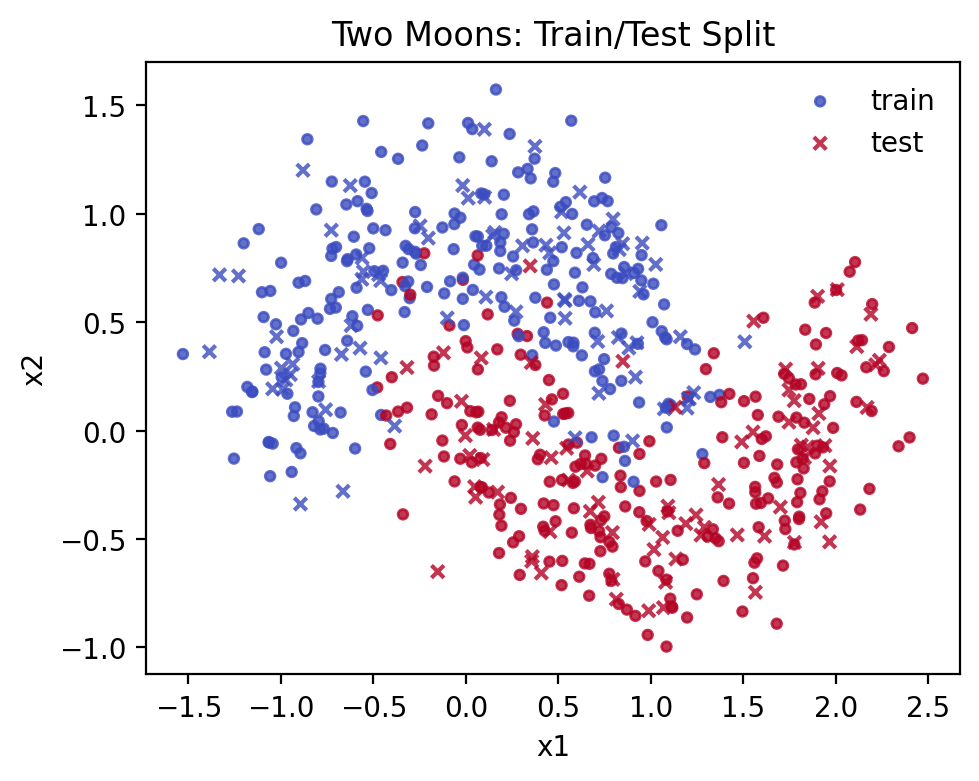

In [6]:
# Visualize the two-moons dataset: train vs test split
import numpy as np  # ensure NumPy is available as np
plt.figure(figsize=(5, 4))  # create a small figure
plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, cmap='coolwarm', s=12, alpha=0.8, label='train')  # train points
plt.scatter(X_te[:, 0], X_te[:, 1], c=y_te, cmap='coolwarm', s=20, alpha=0.8, marker='x', label='test')  # test points
plt.title('Two Moons: Train/Test Split')  # figure title
plt.xlabel('x1')  # x-axis label
plt.ylabel('x2')  # y-axis label
plt.legend(loc='best', frameon=False)  # add legend without frame
plt.tight_layout()  # adjust layout
plt.show()  # render the plot


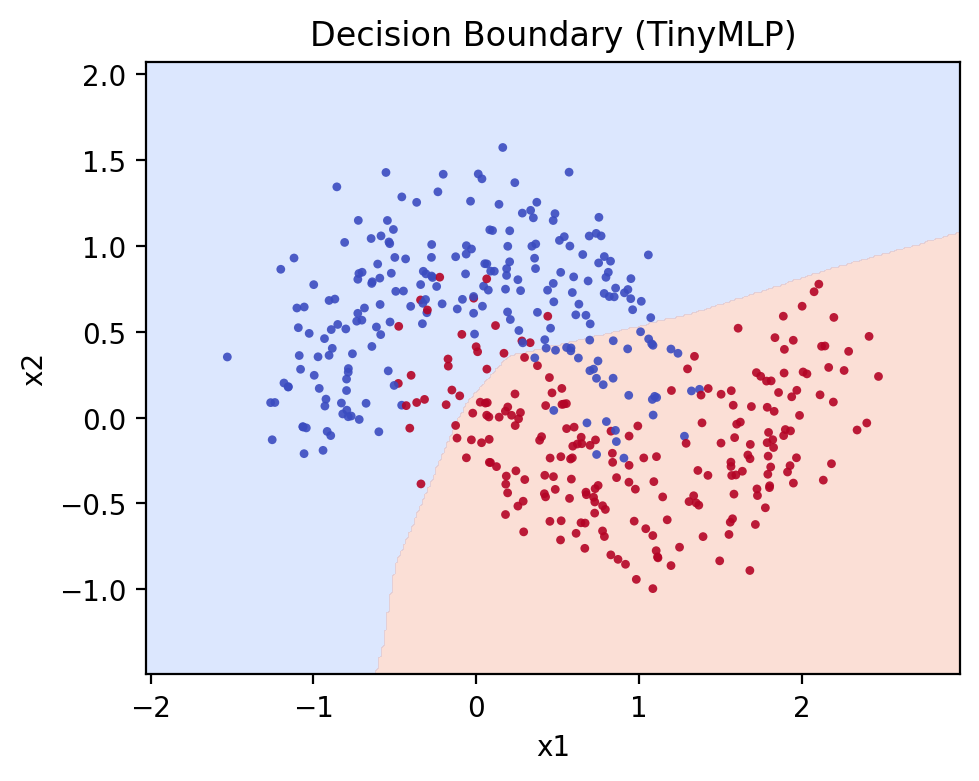

In [7]:
# Plot decision boundary of the trained TinyMLP on the original (unstandardized) features
model.eval()  # evaluation mode for deterministic layers
with torch.no_grad():  # no gradient tracking during visualization
    # Build a grid spanning the feature space with some padding
    x_min, x_max = float(X_tr[:, 0].min()) - 0.5, float(X_tr[:, 0].max()) + 0.5  # x-range
    y_min, y_max = float(X_tr[:, 1].min()) - 0.5, float(X_tr[:, 1].max()) + 0.5  # y-range
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))  # grid
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)  # grid as tensor
    zz = model(grid).argmax(1).view(xx.shape).cpu().numpy()  # class predictions over grid

plt.figure(figsize=(5, 4))  # create a figure
plt.contourf(xx, yy, zz, levels=1, cmap='coolwarm', alpha=0.3)  # filled regions by predicted class
plt.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, cmap='coolwarm', s=10, alpha=0.9, edgecolors='none')  # training points
plt.title('Decision Boundary (TinyMLP)')  # title
plt.xlabel('x1')  # x-axis label
plt.ylabel('x2')  # y-axis label
plt.tight_layout()  # adjust layout
plt.show()  # render the plot

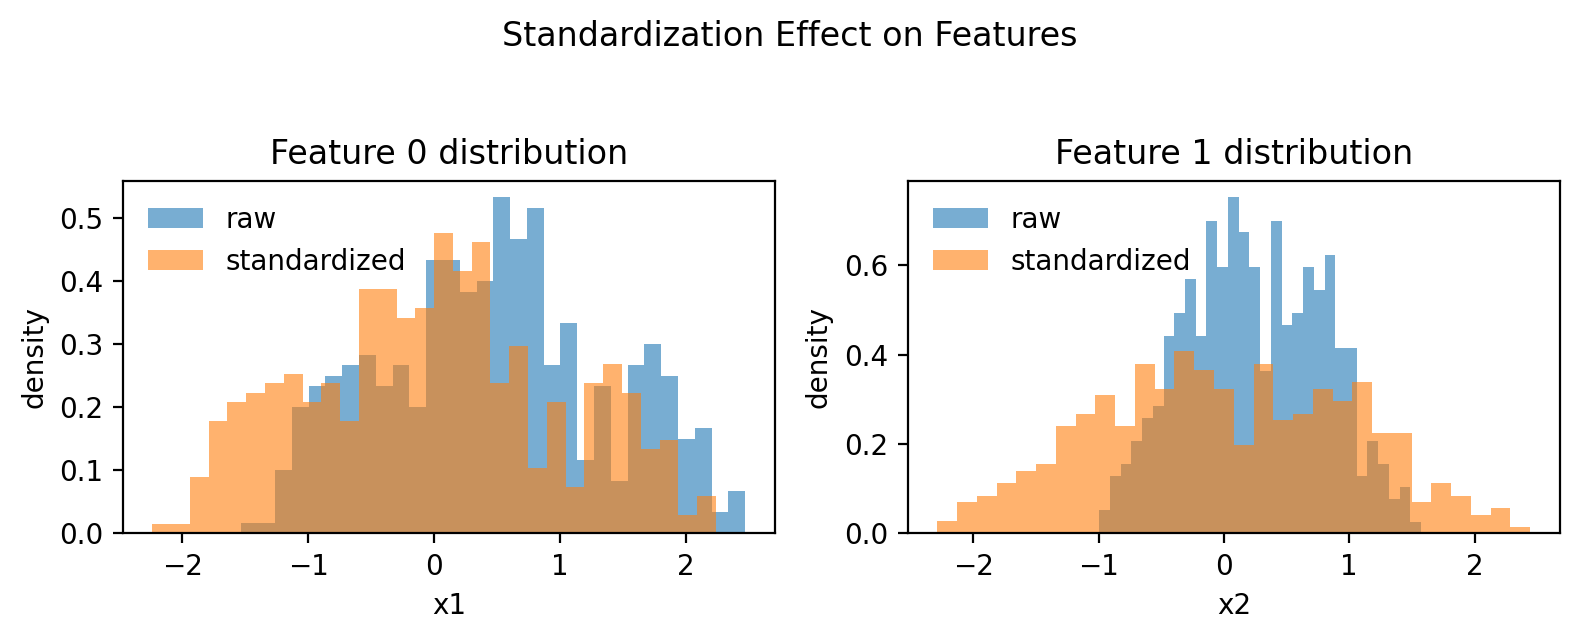

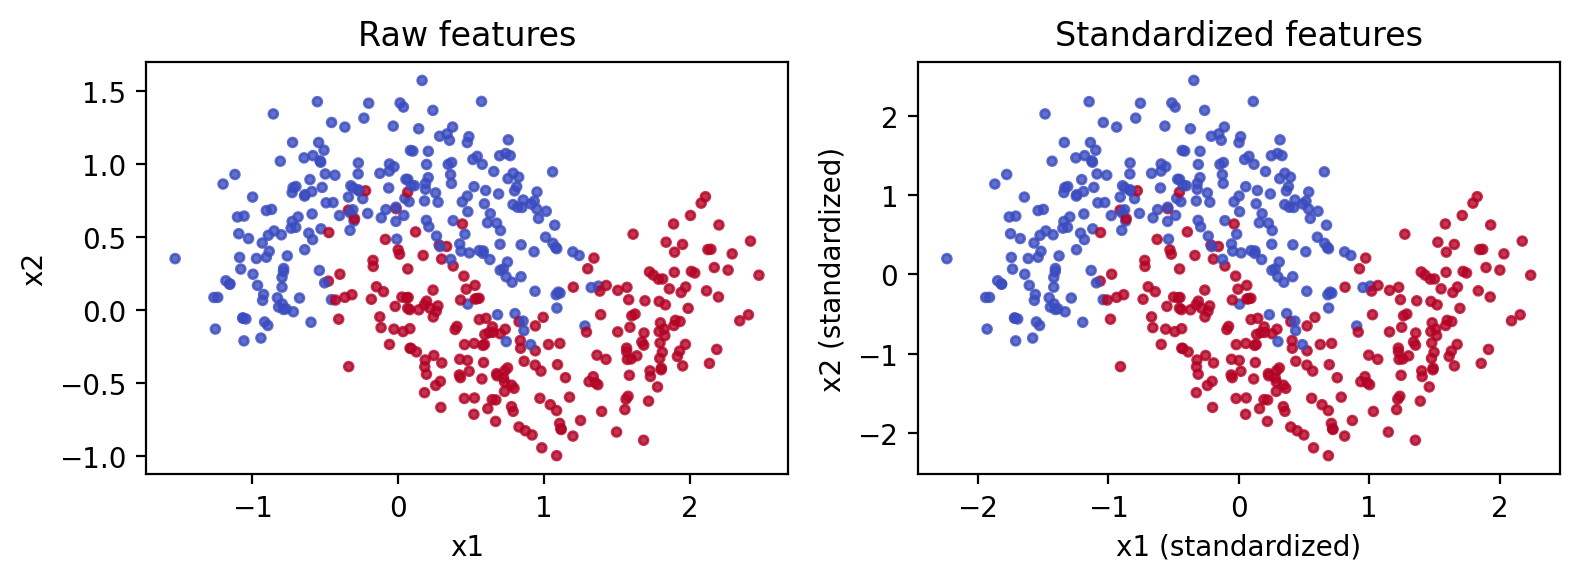

In [8]:
# Visualize feature distributions before and after standardization
# Convert tensors to NumPy for histogram plotting
Xtr_np = X_tr.numpy()  # original training features as NumPy
XtrS_np = X_tr_s.numpy()  # standardized training features as NumPy

fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # two subplots for two features
for i, ax in enumerate(axes):  # iterate over features 0 and 1
    ax.hist(Xtr_np[:, i], bins=30, density=True, alpha=0.6, label='raw')  # raw hist
    ax.hist(XtrS_np[:, i], bins=30, density=True, alpha=0.6, label='standardized')  # standardized hist
    ax.set_title(f'Feature {i} distribution')  # subplot title
    ax.set_xlabel(f'x{i+1}')  # x-axis label
    ax.set_ylabel('density')  # y-axis label
    ax.legend(frameon=False)  # legend without frame
fig.suptitle('Standardization Effect on Features', y=1.05)  # figure title
plt.tight_layout()  # adjust layout
plt.show()  # render the plot

# Side-by-side scatter to show scaling and shape preservation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))  # two side-by-side plots
ax1.scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, cmap='coolwarm', s=10, alpha=0.8)  # raw scatter
ax1.set_title('Raw features')  # title for raw
ax1.set_xlabel('x1')  # x label
ax1.set_ylabel('x2')  # y label
ax2.scatter(X_tr_s[:, 0], X_tr_s[:, 1], c=y_tr, cmap='coolwarm', s=10, alpha=0.8)  # standardized scatter
ax2.set_title('Standardized features')  # title for standardized
ax2.set_xlabel('x1 (standardized)')  # x label
ax2.set_ylabel('x2 (standardized)')  # y label
plt.tight_layout()  # adjust layout
plt.show()  # render

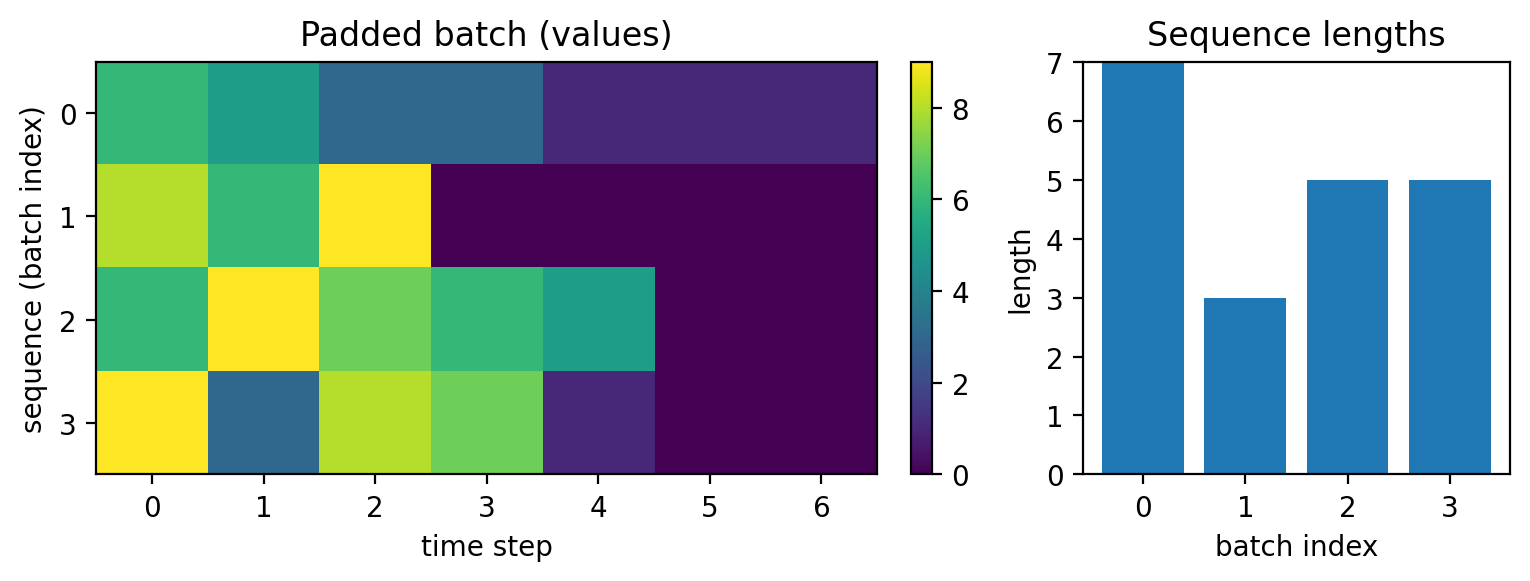

In [9]:
# Visualize a padded ToySeq batch: values heatmap and per-sequence lengths
# Compute lengths by counting non-zero entries (since we used zero-padding)
lengths = (xb > 0).sum(dim=1).cpu().numpy()  # length of each sequence in the batch

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={'width_ratios': [2, 1]})  # two-panel figure
im = ax1.imshow(xb.cpu().numpy(), aspect='auto', cmap='viridis')  # show padded batch as image
ax1.set_title('Padded batch (values)')  # title for heatmap
ax1.set_xlabel('time step')  # x-axis label
ax1.set_ylabel('sequence (batch index)')  # y-axis label
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)  # color bar for value scale

ax2.bar(np.arange(len(lengths)), lengths, color='tab:blue')  # bar chart of lengths
ax2.set_title('Sequence lengths')  # title for bar chart
ax2.set_xlabel('batch index')  # x-axis label
ax2.set_ylabel('length')  # y-axis label
ax2.set_ylim(0, xb.size(1))  # make y-limit consistent with max padded length
plt.tight_layout()  # adjust layout
plt.show()  # render figure